In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm
from collections import Counter
from matplotlib.colors import LogNorm

# Get Data

In [2]:
conn = sqlite3.connect("./im.db")
cur = conn.cursor()
cur.execute("select * from all_data")
res = cur.fetchall()
conn.close()

In [3]:
res[0]

('tt0071562',
 'The Godfather: Part II (1974)',
 '9.0',
 'tt0068646|tt0099674|tt0110912|tt0099685|tt0111161|tt0109830|tt0108052|tt0137523|tt0468569|tt0133093|tt0120815|tt0167260',
 'Crime|Drama',
 'USA',
 'Francis Ford Coppola',
 '1974-12-20')

In [4]:
cols = ['movie_id', 'title', 'rate', 'recommended', 'genres', 'country', 'director', 'date']
data = pd.DataFrame(res, columns=cols)

# Feature Engineering
Most of the things in this section needed for visualizations and for *graph convolution* step. You can skip it, if only interested in graph visualizations and embeddings.

## One Hot encoding for Genres

In [5]:
allgenres = set()
for genres in tqdm(data['genres'].values):
    [allgenres.add(g) for g in genres.split('|')]
    
allgenres -= {''}
print(allgenres)

100%|██████████| 175898/175898 [00:00<00:00, 933841.94it/s]

{'Sci-Fi', 'Thriller', 'Crime', 'Horror', 'Sport', 'Family', 'Drama', 'Fantasy', 'Romance', 'Music', 'Reality-TV', 'Adult', 'Comedy', 'War', 'Documentary', 'Adventure', 'Mystery', 'Animation', 'Game-Show', 'Talk-Show', 'Biography', 'History', 'News', 'Action', 'Film-Noir', 'Musical', 'Short', 'Western'}


In [6]:
for genre in tqdm(allgenres):
    data['Genre_{}'.format(genre)] = data['genres'].apply(lambda x: int(genre in x))

100%|██████████| 28/28 [00:02<00:00, 12.71it/s]


## Rate to numeric

In [7]:
data['rate'] = data['rate']\
    .apply(lambda x: pd.to_numeric(x, downcast='float', errors='coerce'))

## Encode Directors

In [8]:
drctr = Counter(data['director'].values)
drctr.most_common(10)

[('None', 30700),
 ('Kevin Dunn', 195),
 ('Georges Méliès', 181),
 ('Chuck Jones', 179),
 ('Friz Freleng', 146),
 ('Jesús Franco', 137),
 ('Fred Olen Ray', 120),
 ('David DeCoteau', 114),
 ('Joseph Barbera', 113),
 ('Michael Curtiz', 112)]

In [9]:
drctr["None"] = 1
data['director_count'] = data['director'].apply(lambda x: drctr[x])

We need some numerical features to propagate through graph

In [10]:
data['director_mean_rate'] = data[['rate', 'director']]\
            .groupby('director')['rate'].transform('mean')
data['director_min_rate'] = data[['rate', 'director']]\
            .groupby('director')['rate'].transform('min')
data['director_max_rate'] = data[['rate', 'director']]\
            .groupby('director')['rate'].transform('max')
data['director_std_rate'] = data[['rate', 'director']]\
            .groupby('director')['rate'].transform('std')

## Add Year

In [11]:
def get_year(x):
    try:
        return int(x.split('-')[0])
    except ValueError:
        return np.nan

data['year'] = data['date'].apply(get_year)

## Join iMDB official dataset
Description: https://www.imdb.com/interfaces/  
Source: https://datasets.imdbws.com/

In [12]:
imdb_basic = pd.read_csv('./data/title.basics.tsv.gz', sep='\t', na_values='\\N')

/home/sv9t/py36venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
imdb_basic.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,NaN,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1,"Comedy,Short"


In [14]:
imdb_basic['titleType'].unique()

array(['short', 'movie', 'tvMovie', 'tvSeries', 'tvEpisode', 'tvShort',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

In [15]:
data = data.merge(imdb_basic[['tconst', 'titleType', 'runtimeMinutes']]\
                 .rename(columns={'tconst': 'movie_id'}),
                  on='movie_id', how='left')

In [50]:
data['runtimeMinutes'] = data['runtimeMinutes'].astype(np.float32)

In [16]:
data.head()

,movie_id,title,rate,recommended,genres,country,director,date,Genre_Sci-Fi,Genre_Thriller,...,Genre_Short,Genre_Western,director_count,director_mean_rate,director_min_rate,director_max_rate,director_std_rate,year,titleType,runtimeMinutes
0,tt0071562,The Godfather: Part II (1974),9.0,tt0068646|tt0099674|tt0110912|tt0099685|tt0111...,Crime|Drama,USA,Francis Ford Coppola,1974-12-20,0,0,...,0,0,28,6.842857,3.2,9.2,1.473828,1974.0,movie,202
1,tt0468569,The Dark Knight (2008),9.0,tt1345836|tt0372784|tt1375666|tt0137523|tt0109...,Action|Crime|Drama,USA|UK,Christopher Nolan,2008-07-18,0,0,...,0,0,13,8.123077,7.1,9.0,0.615297,2008.0,movie,152
2,tt0110912,Pulp Fiction (1994),8.9,tt0137523|tt0109830|tt1853728|tt0114369|tt0133...,Crime|Drama,USA,Quentin Tarantino,1994-10-14,0,0,...,0,0,14,7.791667,5.7,8.9,0.935617,1994.0,movie,154
3,tt0111161,The Shawshank Redemption (1994),9.3,tt0109830|tt0110912|tt0468569|tt0137523|tt0068...,Crime|Drama,USA,Frank Darabont,1994-10-14,0,0,...,0,0,7,7.171429,5.5,9.3,1.318730,1994.0,movie,142
4,tt0108052,Schindler's List (1993),8.9,tt0109830|tt0110912|tt0120815|tt0111161|tt0102...,Biography|Drama|History,USA,Steven Spielberg,1994-02-04,0,0,...,0,0,44,7.004762,4.4,8.9,0.988212,1994.0,movie,195


In [17]:
data = pd.concat([data,
                  pd.get_dummies(data['titleType'], 
                                dummy_na=True, prefix='type')], axis=1)

In [18]:
data.head()

,movie_id,title,rate,recommended,genres,country,director,date,Genre_Sci-Fi,Genre_Thriller,...,type_movie,type_short,type_tvEpisode,type_tvMiniSeries,type_tvMovie,type_tvSeries,type_tvShort,type_tvSpecial,type_video,type_nan
0,tt0071562,The Godfather: Part II (1974),9.0,tt0068646|tt0099674|tt0110912|tt0099685|tt0111...,Crime|Drama,USA,Francis Ford Coppola,1974-12-20,0,0,...,1,0,0,0,0,0,0,0,0,0
1,tt0468569,The Dark Knight (2008),9.0,tt1345836|tt0372784|tt1375666|tt0137523|tt0109...,Action|Crime|Drama,USA|UK,Christopher Nolan,2008-07-18,0,0,...,1,0,0,0,0,0,0,0,0,0
2,tt0110912,Pulp Fiction (1994),8.9,tt0137523|tt0109830|tt1853728|tt0114369|tt0133...,Crime|Drama,USA,Quentin Tarantino,1994-10-14,0,0,...,1,0,0,0,0,0,0,0,0,0
3,tt0111161,The Shawshank Redemption (1994),9.3,tt0109830|tt0110912|tt0468569|tt0137523|tt0068...,Crime|Drama,USA,Frank Darabont,1994-10-14,0,0,...,1,0,0,0,0,0,0,0,0,0
4,tt0108052,Schindler's List (1993),8.9,tt0109830|tt0110912|tt0120815|tt0111161|tt0102...,Biography|Drama|History,USA,Steven Spielberg,1994-02-04,0,0,...,1,0,0,0,0,0,0,0,0,0


In [19]:
data.columns

Index(['movie_id', 'title', 'rate', 'recommended', 'genres', 'country',
       'director', 'date', 'Genre_Sci-Fi', 'Genre_Thriller', 'Genre_Crime',
       'Genre_Horror', 'Genre_Sport', 'Genre_Family', 'Genre_Drama',
       'Genre_Fantasy', 'Genre_Romance', 'Genre_Music', 'Genre_Reality-TV',
       'Genre_Adult', 'Genre_Comedy', 'Genre_War', 'Genre_Documentary',
       'Genre_Adventure', 'Genre_Mystery', 'Genre_Animation',
       'Genre_Game-Show', 'Genre_Talk-Show', 'Genre_Biography',
       'Genre_History', 'Genre_News', 'Genre_Action', 'Genre_Film-Noir',
       'Genre_Musical', 'Genre_Short', 'Genre_Western', 'director_count',
       'director_mean_rate', 'director_min_rate', 'director_max_rate',
       'director_std_rate', 'year', 'titleType', 'runtimeMinutes',
       'type_movie', 'type_short', 'type_tvEpisode', 'type_tvMiniSeries',
       'type_tvMovie', 'type_tvSeries', 'type_tvShort', 'type_tvSpecial',
       'type_video', 'type_nan'],
      dtype='object')

### Note
There could be great features extracted from country, but this column is very noisy. For example there are mixed country names and languages, different names for same things, city and state names etc. So it needs a lot of preprocessing. Here I want only to show the idea how to handle graphs. Maybe later I'll make research on iMDB data, or you will contribute to this repo.

# Prepare data for embedding tools

Here I make edges list and mapping dict from movie IDs to numbers from 0. Most of the graph tools expect such numeration.

In [20]:
mapping_dict = dict()
counter = 0
edges = []
for movie_id, recs in tqdm(data[['movie_id', 'recommended']].values):
    if movie_id in mapping_dict:
        source = mapping_dict[movie_id]
    else:
        source = counter
        mapping_dict[movie_id] = counter
        counter += 1
    
    for rec_id in recs.split('|'):
        if rec_id in mapping_dict:
            target = mapping_dict[rec_id]
        else:
            target = counter
            mapping_dict[rec_id] = counter
            counter += 1
            
        edges.append((source, target))

100%|██████████| 175898/175898 [00:01<00:00, 154385.79it/s]


LargeViz expects source, target and weight column separated by whitespace.

In [21]:
inverse_mapping = {v: k for k, v in mapping_dict.items()}

In [22]:
edges = pd.DataFrame(edges, columns=['source', 'target'])
edges.head()

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [23]:
edges['weight'] = 1

In [ ]:
edges.to_csv('./data/edges_imdb.csv', header=None, index=False, sep=' ')

# LargeViz

It's one of my favourite graph visualization tool. It can easily handle billions of edges and vertices. LargeViz can also be used for dimension reduction of tabular data.  

https://github.com/lferry007/LargeVis  
It builds and works literally as described in readme. In my case run command looks like this:

```
./LargeVis -input ~/path_to/edges_imdb.csv -output ~/path_to/data/imdb_lv.csv -fea 0 -threads 11 -outdim 2
```

Do not forget `-fea` parameter. By default it set to 1, that means tabular data will be passed to input. In this case we use graph data, so `-fea` must be set to 0.

In [27]:
# Load results
lvdf = pd.read_csv('./data/imdb_lv.csv', header=None, sep=' ',
                   skiprows=1, names=['x', 'y'])

In [28]:
lvdf.head()

,x,y
0,-15.770826,11.584019
1,-15.569892,11.801545
2,-15.616784,11.758538
3,-15.849620,11.510214
4,-15.513492,11.773024


Here I add features I want to color my plots

In [31]:
lvdf['movie_id'] = [inverse_mapping[i] for i in lvdf.index]
lvdf = lvdf.merge(data[['movie_id', 'rate', 'year', 'runtimeMinutes']],
                  on='movie_id', how='left')

Let's draw density

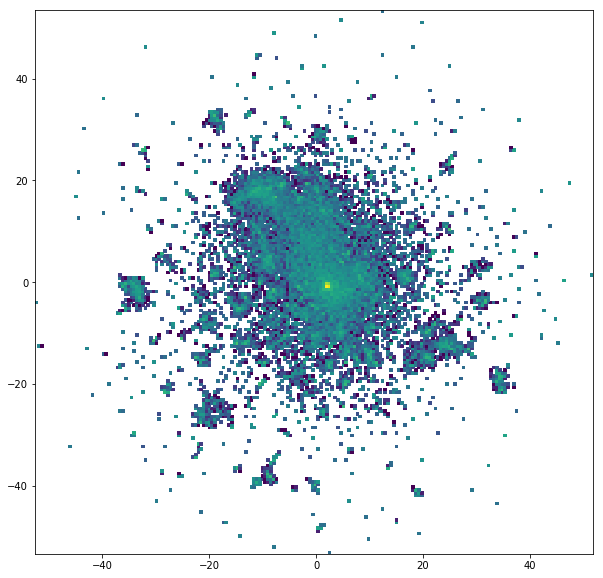

In [32]:
plt.figure(figsize=(10, 10))
plt.hist2d(lvdf['x'].values, lvdf['y'].values, bins=200, norm=LogNorm());

I have choosen a few random movies that must be very different from each other. Not true random, because I pick several points located in different clusters from my another iMDB visualization: http://iggisv9t.xyz/imdb/index.html  
I also have added couple of popular movies.  
Let's look where are they located in this embeddings.

In [30]:
movs = [('tt2351177', 'Bhooter Bhabishyat (2012)'),
        ('tt0024302', "Man's Castle (1933)"),
        ('tt0184316', 'There Was Once a King... (1955)'),
        ('tt0062322', 'Dry Summer (1963)'), 
        ('tt0168526', 'Queen: Bohemian Rhapsody (Video 1975)'),
        ('tt0071853', 'Monty Python and the Holy Grail (1975)'),
        ('tt0468569', 'The Dark Knight (2008)')]

In [86]:
def make_scatter(df, color_by='rate'):
    plt.figure(figsize=(20, 20))
    plt.scatter(df['x'].values, df['y'].values,
                c=df[color_by].values, marker='.', alpha=0.1, cmap='jet')

    for mid, title in movs:
        x, y = df[df['movie_id'] == mid][['x', 'y']].values[0]
        plt.annotate(title, xy=(x, y), xytext=(x - 3, y - 3),
                arrowprops=dict(facecolor='black', shrink=0.05))

In [88]:
def make_genre_plots(df, path):
    xmin, xmax = df['x'].min(), df['x'].max()
    ymin, ymax = df['y'].min(), df['y'].max()

    for genre in allgenres:
        subset = data[data['Genre_{}'.format(genre)] == 1]['movie_id'].values
        mask = df['movie_id'].isin(subset)

        plt.figure(figsize=(20, 20))
        plt.scatter(df['x'][mask].values, df['y'][mask].values,
                    c=df['rate'][mask].values, marker='.', alpha=0.4, cmap='jet')
        plt.title(genre)
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])

        plt.savefig(path + genre + '.png')
        plt.close()

Plot is colored by rate

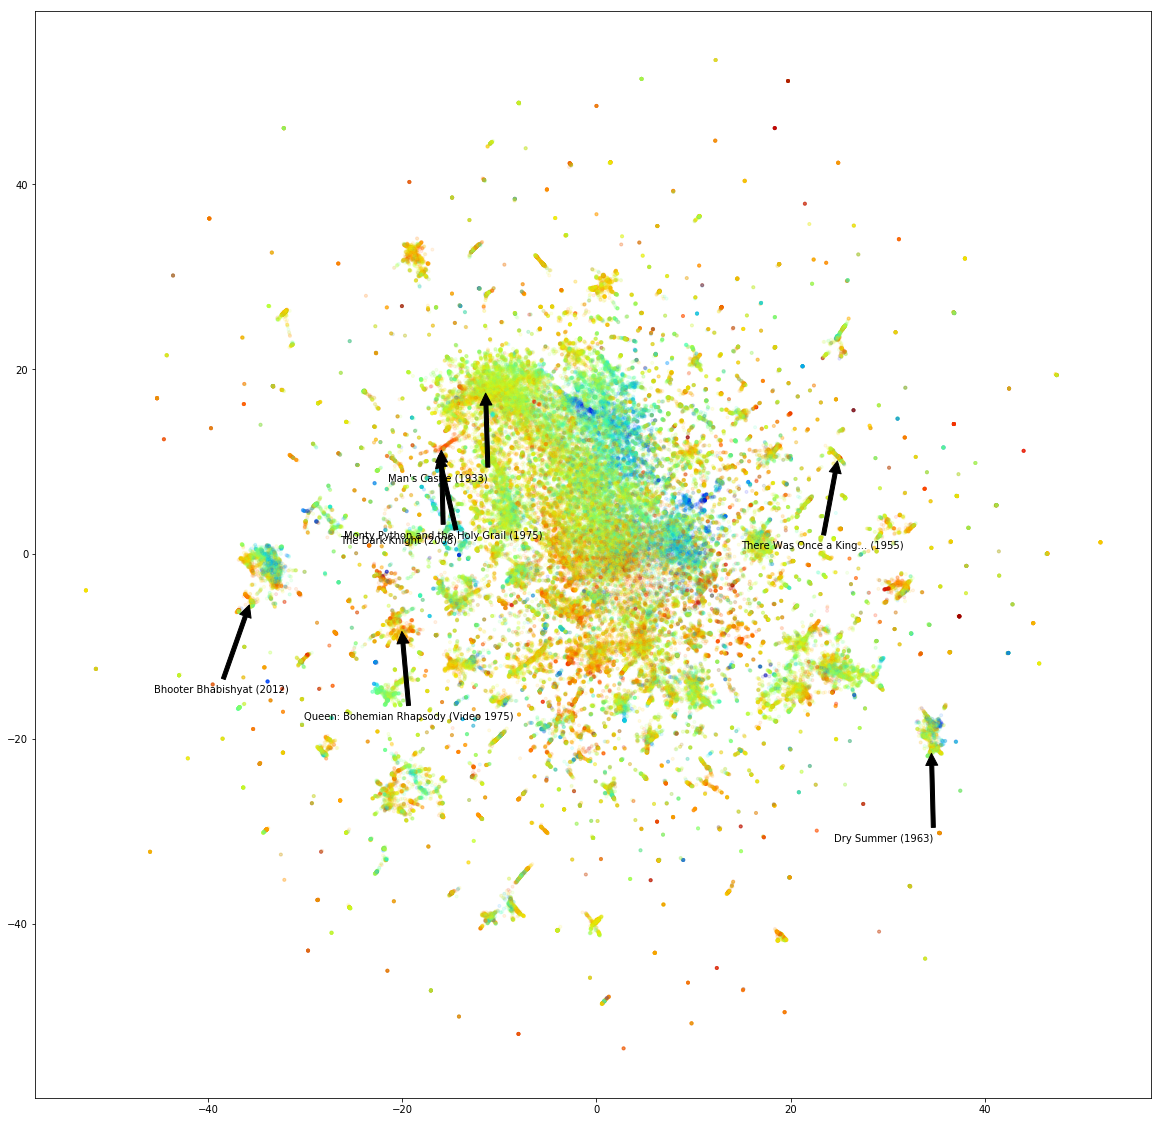

In [34]:
make_scatter(lvdf)

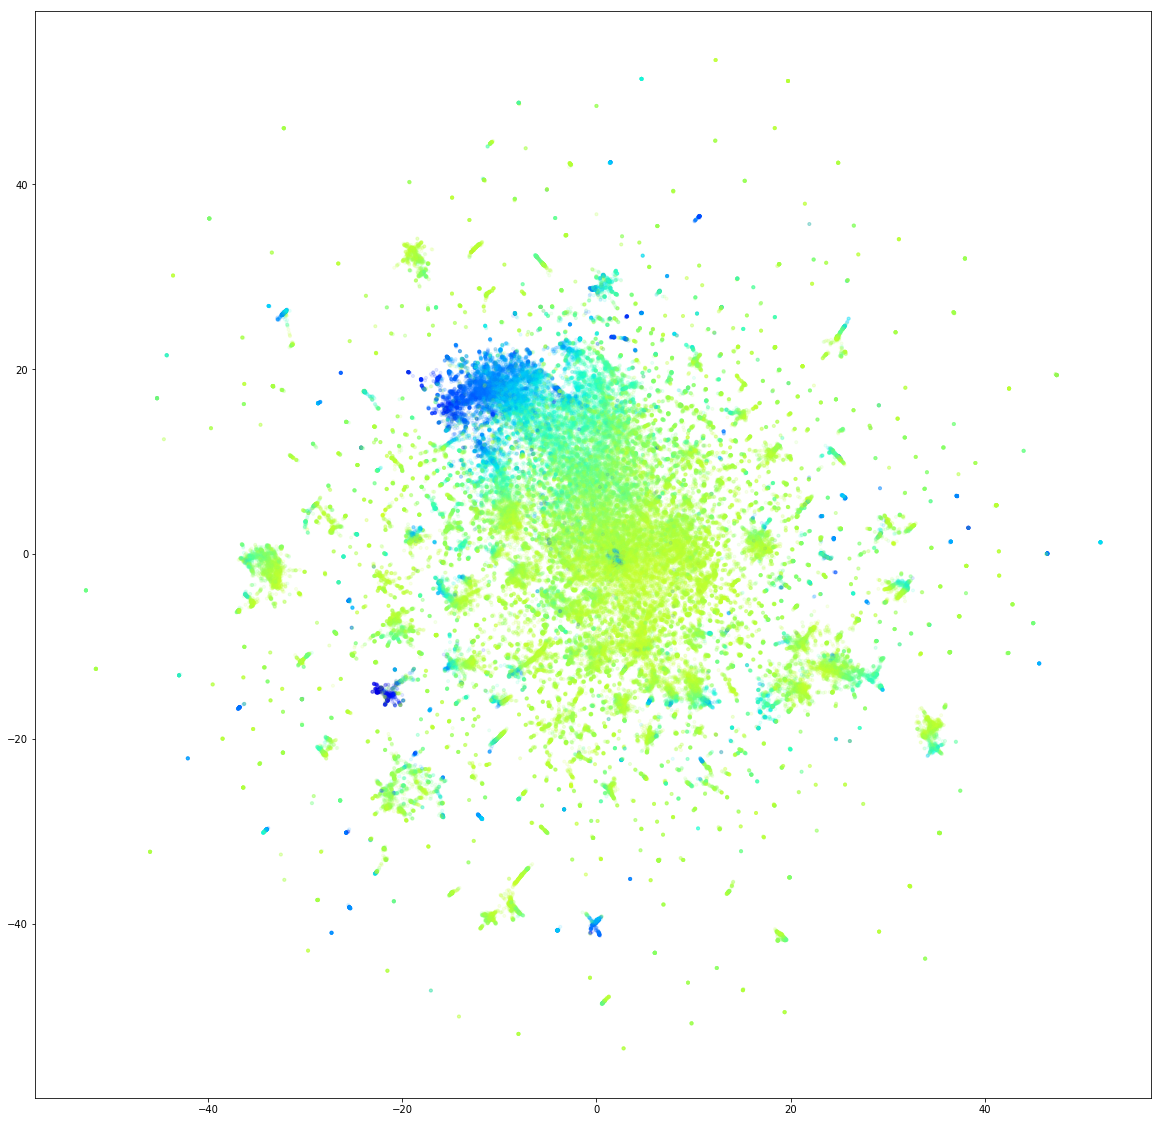

In [35]:
make_scatter(lvdf, color_by='year')

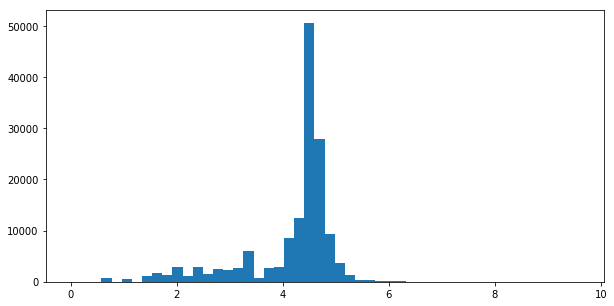

In [46]:
plt.figure(figsize=(10, 5))
plt.hist(lvdf['runtimeMinutes'].astype(np.float32).apply(np.log1p).values, bins=50);

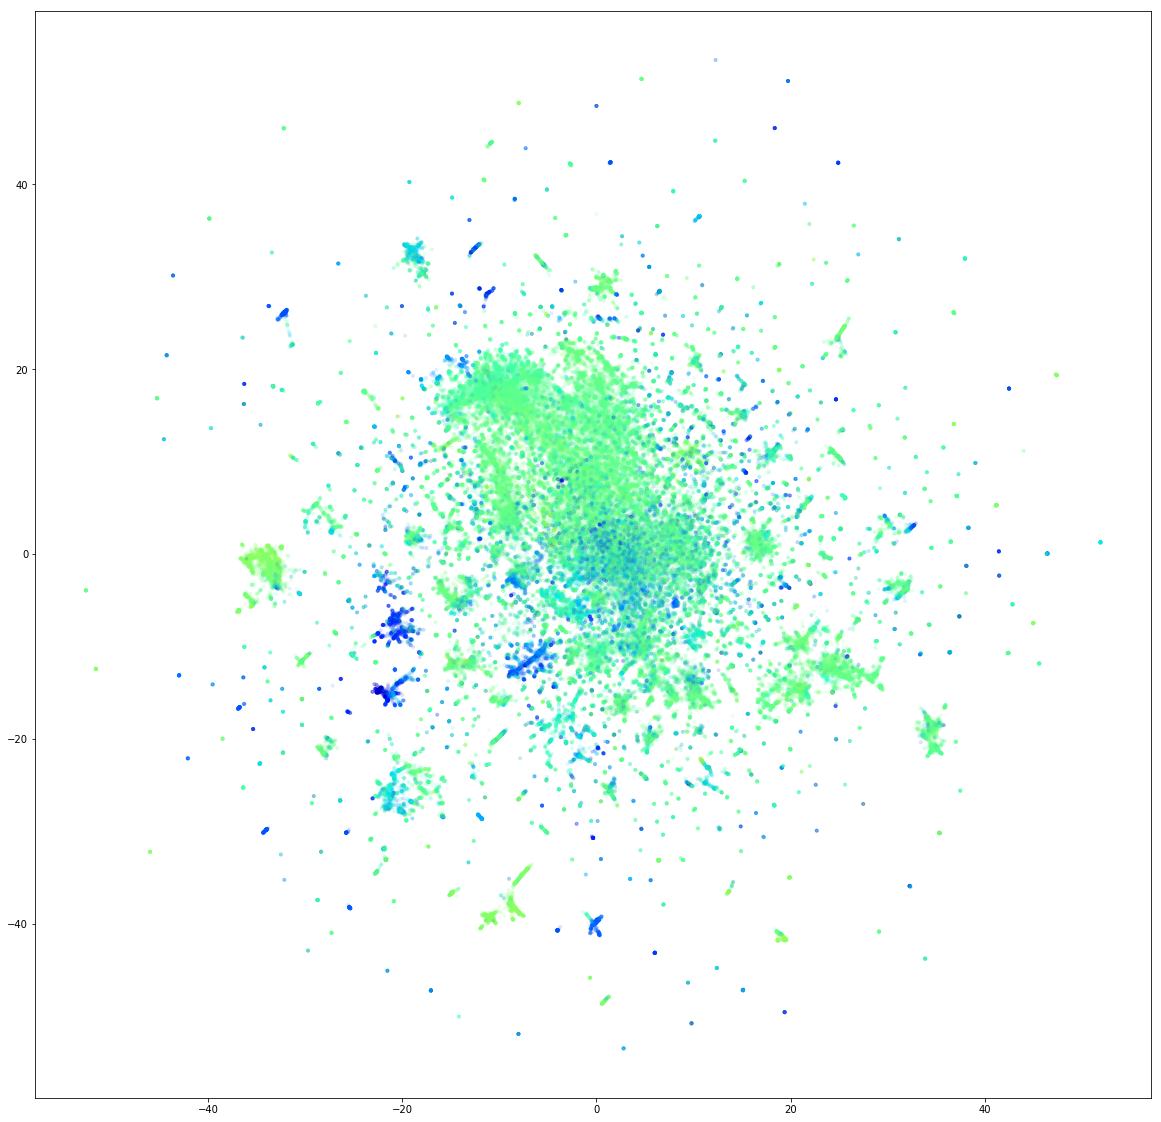

In [47]:
make_scatter(lvdf, color_by='runtimeMinutes')

It worth to mention, that this embeddings are based only on recommendations graph. No information about any movie attributes was passed, but graph itself is rich enough to contain some information about nodes attributes.

In [38]:
make_genre_plots(lvdf, './pics/lv/')

![Convs emb by genres](./pics/lv/anim.gif)

# VERSE
http://tsitsul.in/publications/verse/  
https://github.com/xgfs/verse  

tl;dr:  
VERSE is awesome. Fast, scalable and produces a good embeddings.

There are several widely knonw graph embedding technics such as node2vec or deepWalk, but they only use information about node neighbourhood. VERSE uses graph features to keep in mind node similarity. Better read the original paper.

### Here is example how to use it
Graph conversion to .bcsr format:
```
python ./python/convert.py --format weighted_edgelist --directed ~/path_to/data/edges_imdb.csv ~/path_to/data/imdb.bcsr
```
from VERSE root dir.

```
./src/verse -input /path_to/data/imdb.bcsr -dim 64 -threads 11 -output /path_to/data/imdb_verse.bin
```
Also from the VERSE dir.  

Then read results this way:
```
np.fromfile('embedding.bin', np.float32).reshape(num_nodes, embedding_dim)
```

In [24]:
import umap

In [25]:
verse_emb = np.fromfile('data/imdb_verse.bin', np.float32).reshape(175887, 64)

In [26]:
%%time
reducer = umap.UMAP()
verse_umap = reducer.fit_transform(verse_emb)

/home/sv9t/py36venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 17 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 10min 42s, sys: 2min 40s, total: 13min 23s
Wall time: 3min 12s


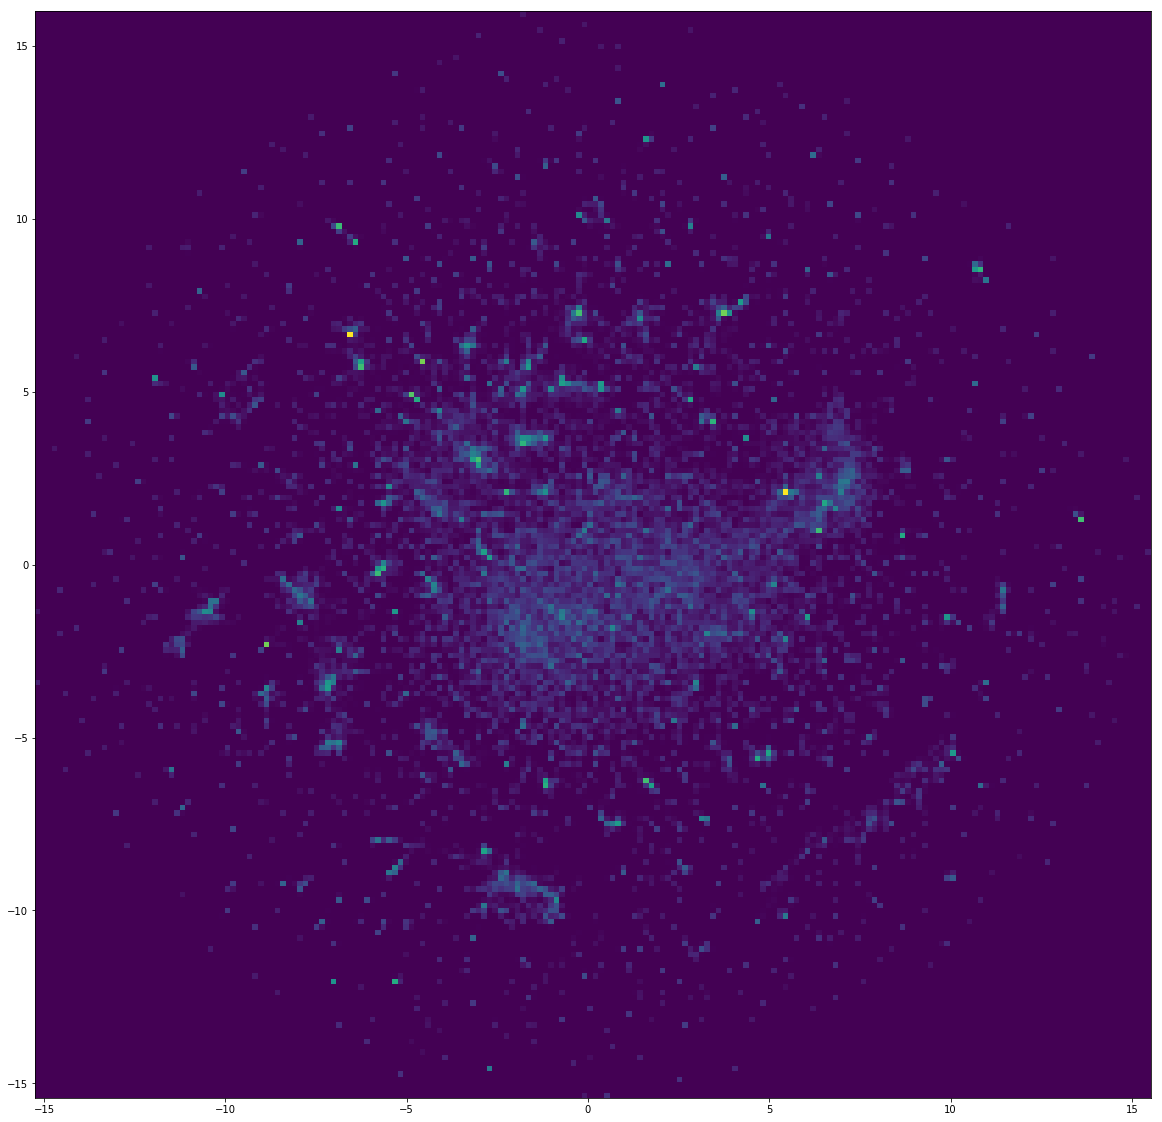

In [27]:
plt.figure(figsize=(20, 20))
plt.hist2d(verse_umap[:, 0], verse_umap[:, 1],
            bins=200);

In [28]:
verse_df = pd.DataFrame(verse_umap, columns=['x', 'y'])
verse_df['movie_id'] = [inverse_mapping[i] for i in range(verse_df.shape[0])]
verse_df = verse_df.merge(data[['movie_id', 'rate', 'year']], on='movie_id', how='left')

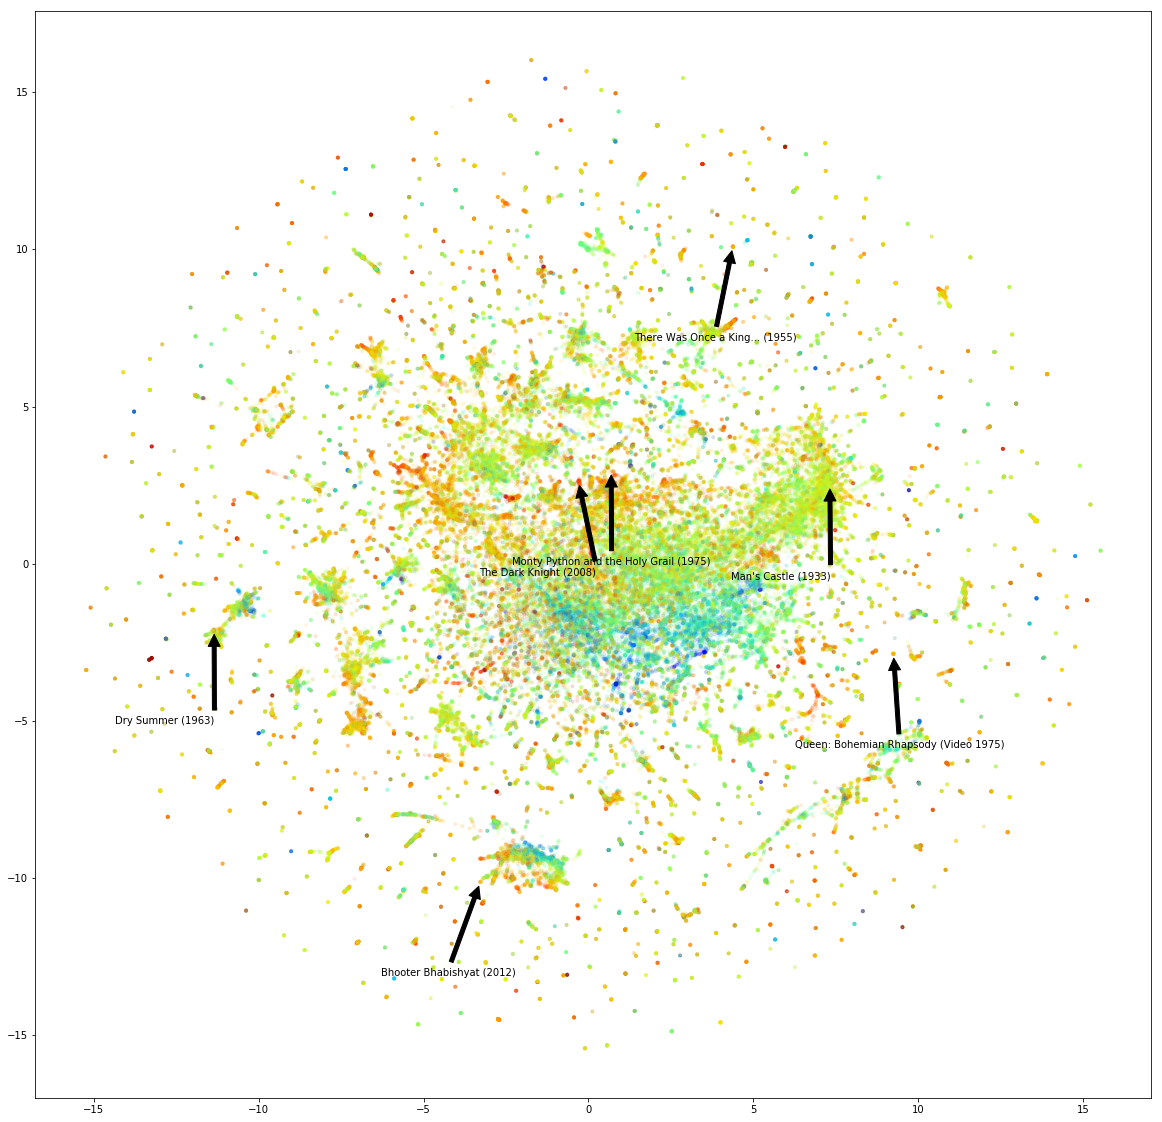

In [31]:
make_scatter(verse_df)

# Convolutions

This function described in separate notebook. No need to copypast it everywhere.

In [32]:
from convolver import make_conv

It's not the best graph to demonstrate power of graph convolutions. Here I extract simple graph feature: out degree of every node. For some graphs there are a lot meaningful features such as number of triangles each node in, difference between in and out degrees or some other features that gives information about local topology. In this graph local topology is not so important, but number of recommended movies may indicate how popular this movie is. Information about popularity of the neighbour also make sense obviously.

In [35]:
data['num_recs'] = data['recommended'].apply(lambda x: len(x.split('|')))

For one-hot features only few aggregation functions (used as pooling) are meaningful. We will handle it separately. For example, there is sense in summing them, but no sense to look at standard deviation of binary feature. On the other hand there is no sense in sum of numerical feature, but most of common statistics should work good.

In [51]:
feats_ohe = ['Genre_Sci-Fi', 'Genre_Thriller', 'Genre_Crime',
       'Genre_Horror', 'Genre_Sport', 'Genre_Family', 'Genre_Drama',
       'Genre_Fantasy', 'Genre_Romance', 'Genre_Music', 'Genre_Reality-TV',
       'Genre_Adult', 'Genre_Comedy', 'Genre_War', 'Genre_Documentary',
       'Genre_Adventure', 'Genre_Mystery', 'Genre_Animation',
       'Genre_Game-Show', 'Genre_Talk-Show', 'Genre_Biography',
       'Genre_History', 'Genre_News', 'Genre_Action', 'Genre_Film-Noir',
       'Genre_Musical', 'Genre_Short', 'Genre_Western', 'type_movie', 'type_short', 'type_tvEpisode', 'type_tvMiniSeries',
       'type_tvMovie', 'type_tvSeries', 'type_tvShort', 'type_tvSpecial',
       'type_video', 'type_nan']

feats_num = ['rate', 
        'director_count',
       'director_mean_rate', 'director_min_rate', 'director_max_rate',
       'director_std_rate', 'year', 'runtimeMinutes', 'num_recs']

In [34]:
data['node_id'] = data['movie_id'].apply(lambda x: mapping_dict[x])

In [43]:
conv_ohe_forward = make_conv(edges, data.rename(columns={'node_id': 'source'}),
                             feats_ohe, by='target', on='source',
                             prefix='mean_f_')

conv_ohe_backward = make_conv(edges, data.rename(columns={'node_id': 'target'}),
                             feats_ohe, by='source', on='target',
                             prefix='mean_b_')

100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


In [44]:
conv_ohe_backward.head()

,source,mean_b_Genre_Sci-Fi,mean_b_Genre_Thriller,mean_b_Genre_Crime,mean_b_Genre_Horror,mean_b_Genre_Sport,mean_b_Genre_Family,mean_b_Genre_Drama,mean_b_Genre_Fantasy,mean_b_Genre_Romance,...,mean_b_type_movie,mean_b_type_short,mean_b_type_tvEpisode,mean_b_type_tvMiniSeries,mean_b_type_tvMovie,mean_b_type_tvSeries,mean_b_type_tvShort,mean_b_type_tvSpecial,mean_b_type_video,mean_b_type_nan
0,0,0.083333,0.000000,0.500000,0.0,0.0,0.0,0.916667,0.083333,0.083333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.083333,0.083333,0.583333,0.0,0.0,0.0,0.916667,0.083333,0.083333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.083333,0.083333,0.583333,0.0,0.0,0.0,0.750000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.166667,0.166667,0.416667,0.0,0.0,0.0,0.833333,0.000000,0.083333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.000000,0.083333,0.750000,0.0,0.0,0.0,1.000000,0.000000,0.083333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
conv_ohe_forward.head()

,target,mean_f_Genre_Sci-Fi,mean_f_Genre_Thriller,mean_f_Genre_Crime,mean_f_Genre_Horror,mean_f_Genre_Sport,mean_f_Genre_Family,mean_f_Genre_Drama,mean_f_Genre_Fantasy,mean_f_Genre_Romance,...,mean_f_type_movie,mean_f_type_short,mean_f_type_tvEpisode,mean_f_type_tvMiniSeries,mean_f_type_tvMovie,mean_f_type_tvSeries,mean_f_type_tvShort,mean_f_type_tvSpecial,mean_f_type_video,mean_f_type_nan
0,0,0.000000,0.000000,0.636364,0.000000,0.00,0.0,0.727273,0.000000,0.00000,...,0.818182,0.090909,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0
1,1,0.000000,0.000000,0.666667,0.000000,0.00,0.0,0.888889,0.000000,0.00000,...,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,2,0.000000,0.200000,0.600000,0.000000,0.00,0.0,0.800000,0.000000,0.00000,...,0.600000,0.200000,0.0,0.2,0.000000,0.0,0.0,0.0,0.0,0.0
3,3,0.095238,0.166667,0.547619,0.047619,0.00,0.0,0.809524,0.071429,0.02381,...,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,4,0.000000,0.100000,0.650000,0.050000,0.05,0.0,0.850000,0.000000,0.00000,...,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [52]:
conv_num_forward = []
conv_num_backward = []

for agg_f in ['mean', 'std', 'min', 'max']:
    conv_num_forward.append(make_conv(edges,
                                 data.rename(columns={'node_id': 'source'}),
                                 feats_num, by='target', on='source',
                                 agg_f=agg_f, prefix=agg_f + '_f_'))

    conv_num_backward.append(make_conv(edges,
                                 data.rename(columns={'node_id': 'target'}),
                                 feats_num, by='source', on='target',
                                 agg_f=agg_f, prefix=agg_f + '_b_'))

100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


In [53]:
conv_num_forward[0].head()

,target,mean_f_rate,mean_f_director_count,mean_f_director_mean_rate,mean_f_director_min_rate,mean_f_director_max_rate,mean_f_director_std_rate,mean_f_year,mean_f_runtimeMinutes,mean_f_num_recs
0,0,8.660000,23.363636,7.041441,5.109091,8.536363,1.039678,1983.272727,142.909088,11.363636
1,1,8.344444,28.000000,6.960968,4.877778,8.677778,1.008369,1980.333333,150.444443,11.777778
2,2,8.820000,13.600000,7.104611,3.360000,9.020000,1.392249,1988.250000,196.000000,12.000000
3,3,8.521429,23.523810,7.355883,5.478571,8.807143,0.926521,1993.952381,142.166672,12.000000
4,4,8.465000,25.800000,7.184055,5.080000,8.725000,0.996101,1984.300000,150.199997,12.000000


Crazy dimesionality, I know.

## Glue them together

In [54]:
dfs = [conv_ohe_backward] + [conv_ohe_forward] + conv_num_backward + conv_num_forward

In [55]:
# we don't need this 'source' and 'target' columns
dfs = [df[list(df.columns)[1:]] for df in dfs]

In [73]:
conv_df = pd.concat(dfs, axis=1)

In [57]:
conv_df.head()

,mean_b_Genre_Sci-Fi,mean_b_Genre_Thriller,mean_b_Genre_Crime,mean_b_Genre_Horror,mean_b_Genre_Sport,mean_b_Genre_Family,mean_b_Genre_Drama,mean_b_Genre_Fantasy,mean_b_Genre_Romance,mean_b_Genre_Music,...,min_f_num_recs,max_f_rate,max_f_director_count,max_f_director_mean_rate,max_f_director_min_rate,max_f_director_max_rate,max_f_director_std_rate,max_f_year,max_f_runtimeMinutes,max_f_num_recs
0,0.083333,0.000000,0.500000,0.0,0.0,0.0,0.916667,0.083333,0.083333,0.0,...,5.0,9.3,49.0,8.050000,7.0,9.3,1.473828,2014.0,229.0,12.0
1,0.083333,0.083333,0.583333,0.0,0.0,0.0,0.916667,0.083333,0.083333,0.0,...,10.0,9.3,49.0,7.957143,6.1,9.3,1.473828,1994.0,202.0,12.0
2,0.083333,0.083333,0.583333,0.0,0.0,0.0,0.750000,0.000000,0.000000,0.0,...,12.0,9.5,28.0,8.050000,7.0,10.0,2.088460,2014.0,434.0,12.0
3,0.166667,0.166667,0.416667,0.0,0.0,0.0,0.833333,0.000000,0.083333,0.0,...,12.0,9.3,66.0,8.123077,7.1,9.3,1.473828,2015.0,202.0,12.0
4,0.000000,0.083333,0.750000,0.0,0.0,0.0,1.000000,0.000000,0.083333,0.0,...,12.0,9.2,60.0,7.957143,6.1,9.2,1.473828,2006.0,229.0,12.0


In [58]:
conv_df.shape

(175854, 148)

In [90]:
# Features has different scale
from sklearn.preprocessing import StandardScaler

In [75]:
%%time
ss = StandardScaler(copy=False)
data_ss = ss.fit_transform(conv_df.fillna(conv_df.mean()).values)

CPU times: user 655 ms, sys: 3.67 ms, total: 658 ms
Wall time: 657 ms


In [76]:
%%time
reducer = umap.UMAP()
conv_umap = reducer.fit_transform(data_ss)

/home/sv9t/py36venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 8min 6s, sys: 1min 18s, total: 9min 24s
Wall time: 5min 27s


In [80]:
conv_umap = pd.DataFrame(conv_umap, columns=['x', 'y'])
conv_umap['movie_id'] = [inverse_mapping[i] for i in range(conv_umap.shape[0])]
conv_umap = conv_umap.merge(data[['movie_id', 'rate', 'year']], on='movie_id', how='left')

In [82]:
conv_umap.head()

,x,y,movie_id,rate,year
0,9.002540,-5.434004,tt0071562,9.0,1974.0
1,8.998318,-5.451718,tt0068646,9.2,1972.0
2,8.991608,-5.448453,tt0099674,7.6,1990.0
3,9.067732,-5.450064,tt0110912,8.9,1994.0
4,9.033180,-5.454914,tt0099685,8.7,1990.0


## Visualize it

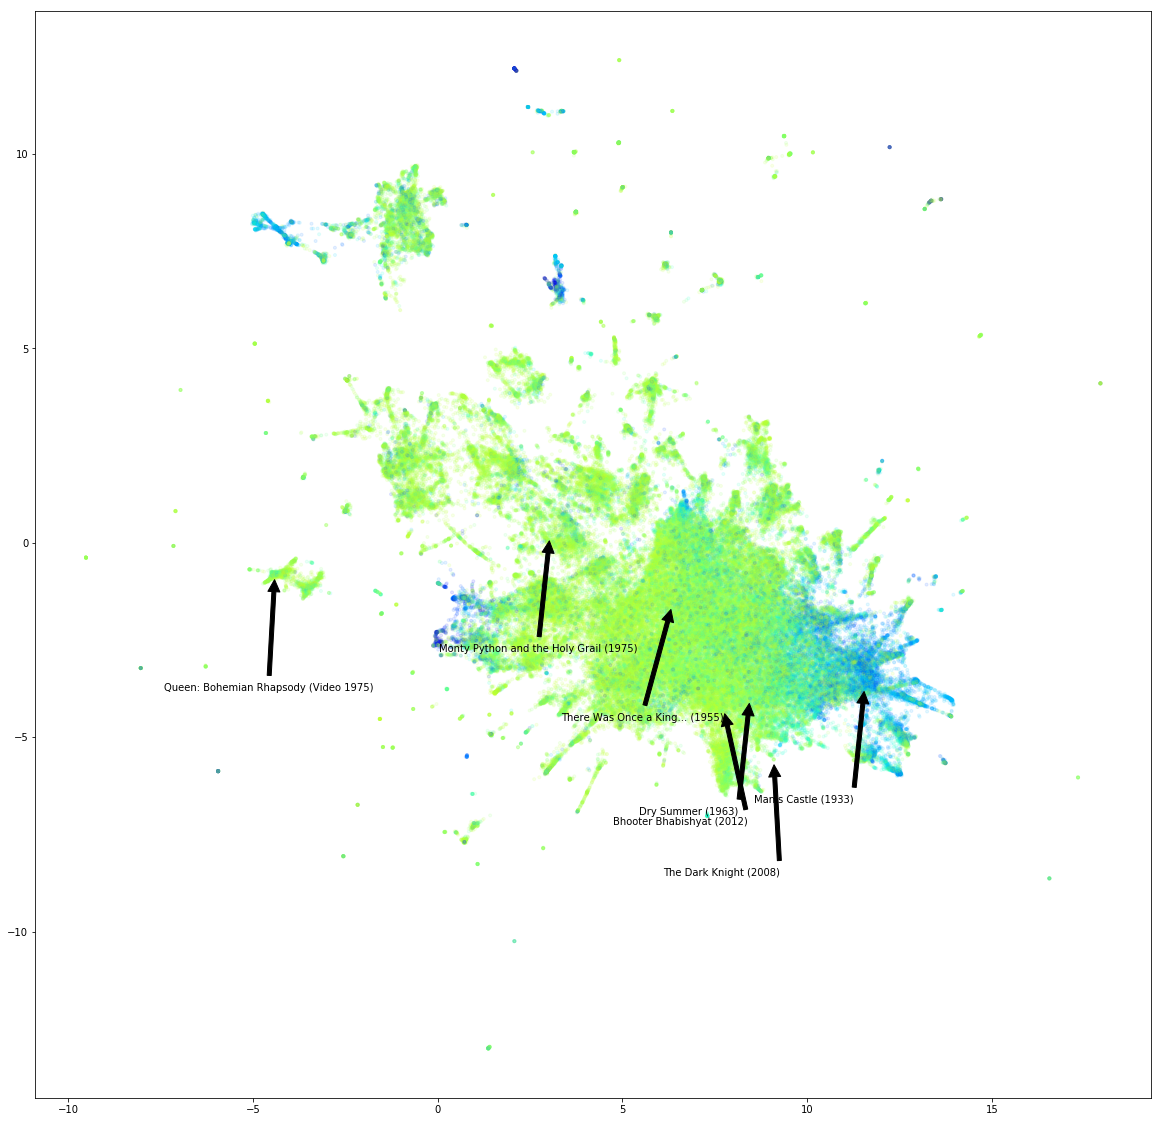

In [85]:
make_scatter(conv_umap, color_by='year')

In [89]:
make_genre_plots(conv_umap, './pics/conv/')

![Convs emb by genres](./pics/conv/anim.gif)

UMAP tries to preserve distances between points when reducing dimensions. It make sense for such methods as LargeViz, Node2Vec or VERSE because they directly estimate closenes of the nodes and they similarity. In case of convolutions we have different scales for different features. Some features also shares common information in it. Look on OHE features in our case for example. So better way to reduce dimensions here is to use autoencoder.